## Project 4:  Solving N-Queens Problem using Genetic Algorithms

#### CSC 180  Intelligent Systems

#### Dr. Haiquan Chen, California State University, Sacramento


In [1]:
# Project 4: Due 4/23
#
# Noah Venethongkham, 219660117
# Ashley Thor, 219334909
# Lucas Saechao, 218794239

## Part I: Position-index-based board representation
By Position-Based indexing, our board is represented by using absolute positions from 0-(N\*N) - 1. For example, the board \[0, 7, 11, 14\] would correspond to the following board:

`
x|-|-|-
-|-|-|x
-|-|-|x
-|-|x|-
`

In [2]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
%matplotlib inline

# run 'pip install deap'
from deap import algorithms, base, creator, tools

## Define problem size.
Our solution supports any board size S, in which S = {x | $x \in N$, $x = 1$, $x>3$}

In [3]:
# board size
board_size = 8

In [4]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [5]:
def create_individual():
    return random.sample(range(board_size * board_size), board_size)

In [6]:
# verify individual
print(create_individual())

[44, 51, 58, 32, 18, 24, 4, 37]


In [7]:
# print grid function
def print_grid(board, board_size):
    dashes = "--------------------------------"
    dashes = dashes[:(board_size * 2)]
    n = [0]*(board_size * board_size)
    for i in board:
        n[i] = 1
    
    count = 0
    for i in range(board_size):
        for j in range(board_size * board_size):
            if j // board_size == i:
                if n[j] == 1:
                    print('X',end="|")
                else:
                    print('-',end="|")
        print()
        print(dashes)

In [8]:
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
pop = toolbox.population(n=1000)

In [9]:
# verify population
print(pop[0])
print_grid(pop[0], board_size)

[37, 59, 36, 5, 46, 8, 43, 27]
-|-|-|-|-|X|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
-|-|-|-|X|X|-|-|
----------------
-|-|-|X|-|-|X|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------


### 10 pts:  Write your code in the below to define the "eval_fitness" function, which returns the fitness of any given board.  

- Notice that in this case, a mutation may generate an invalid board, e.g., a board with dupliciate positions. Consider the board \[5, 32, 8, 8, 41, 3, 55, 49\].

- How can we exclude boards that are explicitly invalid? One way is to add some penalty to the fitness value of invalid boards. In that case, any invalid board will have a very high fitness value (remember that our goal is to find the board with least fitness value).    To do that, let's write a function ***checkDuplicate()*** to calculate the number of queen pairs in the same position for any given board.   ***Give each duplicate a high penalty (i.e., multiply by 20, 50) and add the penalty to the fitness value.*** 

-  eval_fitness() should return the total number of duplicate position pairs (with penalty) and the total number of distinct pairs of queens that attack each other.  

In [10]:
# Calculate the number of queen pairs in the same position for any given board
def check_duplicate(individual):
    dup = 0
    individual_sorted = sorted(individual)
    duplicates=[]
    for i in individual_sorted:
     if individual_sorted.count(i)>1:
         if i not in duplicates:
             duplicates.append(i)
    dup = len(duplicates)
    
    return dup

## eval_fitness()
For a 1D array representing a board with some N queens, the following is done to check for collisions: first an empty dictionary is created. The dictionary is used to keep track of pair mappings in which an integer key maps to a tuple, representing that collision. Then, we check for a vertical, horizontal, and diagonal collision. A helper method unique_tuples() is given this dictionary, and computes a list of distinct conflicts. The size of this list is the number of distinct conflicts found for this board.

In [11]:
def unique_tuples(d):
    unique = []
    for key in d:
        reverse = ()
        item = d[key]
        for i in reversed(item):
            reverse += (i,)
        if item not in unique and reverse not in unique:
            unique.append(item)
    #print(unique)
    return unique

# scan left-to-right diagonals
def check_diag_right(i, j, board_size):
    n_upper = board_size + 1
    right_edge = []
    left_edge = []
    for k in range(board_size * board_size):
        if (k + 1) % board_size == 0:
            right_edge.append(k)
        if k % board_size == 0:
            left_edge.append(k)
    
    # directly adjacent
    if i not in right_edge:
        right = i
        if (right + n_upper) == j:
            return True
    
    if i not in left_edge:
        left = i
        if (left - n_upper) == j:
            return True
    
    if j not in right_edge:
        right = j
        if (right + n_upper) == i:
            return True
    
    if j not in left_edge:
        left = j
        if (left - n_upper) == i:
            return True
    # if i > j scan i to the left else scan j to the left
    for l in range(board_size):
        if i > j:
            if i not in left_edge:
                i -= n_upper
                if i == j:
                    return True
            if j not in right_edge:
                j += n_upper
                if j == i:
                    return True
        else:
            if j not in left_edge:
                j -= n_upper
                if j == i:
                    return True
            if i not in right_edge:
                i += n_upper
                if i == j:
                    return True
    return False

# scan right to left diagonals
def check_diag_left(i, j, board_size):
    n_lower = board_size - 1
    right_edge = []
    left_edge = []
    
    for k in range(board_size * board_size):
        if (k + 1) % board_size == 0:
            right_edge.append(k)
        if k % board_size == 0:
            left_edge.append(k)
    
    # directly adjacent
    if i not in left_edge:
        right = i
        if (right + n_lower) == j:
            return True
    
    if i not in right_edge:
        left = i
        if (left - n_lower) == j:
            return True
    
    if j not in left_edge:
        right = j
        if (right + n_lower) == i:
            return True
    
    if j not in right_edge:
        left = j
        if (left - n_lower) == i:
            return True
    
    # if i > j scan i to the right else scan j to the right
    for l in range(board_size):
        if i > j:
            if i not in right_edge:
                i -= n_lower
                if i == j:
                    return True
            if j not in left_edge:
                j += n_lower
                if j == i:
                    return True
        else:
            if j not in right_edge:
                j -= n_lower
                if j == i:
                    return True
            if i not in left_edge:
                i += n_lower
                if i == j:
                    return True
    return False

def eval_fitness(individual):
    key = 0
    pairs = {}
    n_lower = board_size - 1
    
    for i in individual: 
        for j in individual:
            if i == j:
                continue
            if (i - j) % board_size == 0:
                key += 1
                pairs[key] = (i, j)
            if (math.floor(i / board_size)) == (math.floor(j / board_size)):
                key += 1
                pairs[key] = (i, j)
            if check_diag_right(i, j, board_size): 
                key += 1
                pairs[key] = (i, j)
            if check_diag_left(i, j, board_size):
                key += 1
                pairs[key] = (i, j)
    
    unique = unique_tuples(pairs)
    return ((50*check_duplicate(individual)) + len(unique),)

In [12]:
# verify eval fitness function
print_grid(pop[0], board_size)
print(eval_fitness(pop[0]))

-|-|-|-|-|X|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
-|-|-|-|X|X|-|-|
----------------
-|-|-|X|-|-|X|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
(9,)


### 5 pts:  Write code in the cell below to register the evaluation function to your toolbox object.

In [13]:
# register evaluation function
toolbox.register("evaluate", eval_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low = 0, up = (board_size * board_size), indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [14]:
# initialize statistics object
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

### 10 pts:  Write code in the cell below to create the generation one, a hall of fame, and to launch the genetic algorithm: eaSimple().
Think about how many individuals you want to have per generation and how many generations you want the algorithm to go through for each run. Vary these parameters to see how they affect the outcome.

**The *simple evolutionary algorithm* takes 5 arguments:**
* the population
* the toolbox
* the probability of cross-overing two individuals (`cxpb`)
* the probability of mutating each individual (`mutpb`) 
* the number of generations to accomplish (`ngen`). 

In [15]:
pop = toolbox.population(n=1000)
hof = tools.HallOfFame(maxsize=10)
pop, log = algorithms.eaSimple(
    pop, 
    toolbox, 
    cxpb=0.5, 
    mutpb=0.2, 
    ngen=100, 
    stats=stats, 
    halloffame=hof, 
    verbose=True)

gen	nevals	avg   	min
0  	1000  	10.161	3  
1  	571   	13.185	3  
2  	620   	12.863	3  
3  	577   	11.75 	3  
4  	597   	11.131	3  
5  	609   	10.885	3  
6  	635   	11.334	2  
7  	630   	11.057	2  
8  	596   	10.336	3  
9  	625   	10.919	2  
10 	641   	10.451	2  
11 	639   	10.291	2  
12 	632   	9.984 	1  
13 	611   	9.62  	1  
14 	608   	8.466 	1  
15 	568   	8.263 	2  
16 	602   	7.939 	2  
17 	615   	6.678 	2  
18 	585   	5.244 	2  
19 	591   	5.315 	2  
20 	584   	4.541 	2  
21 	598   	3.581 	1  
22 	587   	3.676 	0  
23 	610   	3.578 	0  
24 	614   	3.91  	0  
25 	606   	3.519 	0  
26 	623   	3.601 	0  
27 	606   	3.013 	0  
28 	597   	2.641 	0  
29 	580   	1.455 	0  
30 	622   	1.496 	0  
31 	610   	0.953 	0  
32 	598   	1.331 	0  
33 	604   	1.898 	0  
34 	572   	1.137 	0  
35 	592   	0.841 	0  
36 	565   	0.892 	0  
37 	652   	1.244 	0  
38 	634   	1.067 	0  
39 	621   	1.315 	0  
40 	642   	0.872 	0  
41 	593   	0.919 	0  
42 	565   	1.078 	0  
43 	655   	1.191 	0  
44 	621   

### 5 pts:  Plot the "avg" and "min" for each generation

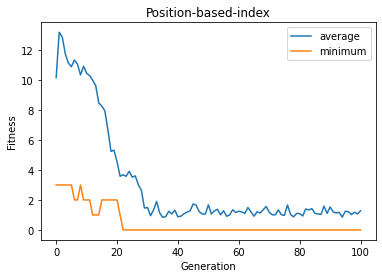

In [16]:
gen, avg, min_ = log.select("gen", "avg", "min")
plt.title("Position-based-index")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()

### 5 pts:  Print out the best individual and its fitness value. Show the best individual as a chessboard.

In [17]:
best_ind = tools.selBest(pop, k=1)[0]
print('Best individual is: {}'.format(best_ind))
if eval_fitness(best_ind)[0] > 0:
    print('Eval Fitness Value: {}'.format(eval_fitness(best_ind)[0]))
else:
    print('Eval Fitness is 0! This board is a valid solution.')
print_grid(best_ind, board_size)

Best individual is: [16, 10, 59, 36, 5, 47, 49, 30]
Eval Fitness is 0! This board is a valid solution.
-|-|-|-|-|X|-|-|
----------------
-|-|X|-|-|-|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
-|-|-|-|X|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------


## Part II: Row-index-based board representation
In row-index based representation, the rows of the chessboard are indexed from 0->7. Each queen can only belong to a single row. The sequence \[ a b c d .... \] means that in $0^{th}$ row, $a^{th}$ column, the queen is present and so on. A good way to think of it is that for each row from 0 to N, each value of a given sequence indicates the *depth* of the queen's location in that row. Consider the board \[0, 1, 1, 3\] for N=4. This would result in the following grid:

```
x|-|-|-
-|x|-|-
-|x|-|-
-|-|-|x
```

In [18]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

/Users/lucassaechao/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/lucassaechao/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [19]:
# reinitialize our toolbox
toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, board_size-1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=board_size)
#toolbox.individual()
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
pop = toolbox.population(n=1000)
print(pop)

[[4, 1, 3, 0, 3, 6, 1, 4], [5, 0, 7, 1, 1, 1, 1, 2], [7, 4, 4, 0, 3, 4, 5, 0], [1, 6, 6, 2, 2, 7, 7, 0], [3, 5, 3, 4, 6, 6, 4, 0], [4, 3, 2, 0, 5, 2, 6, 7], [6, 5, 7, 7, 0, 1, 2, 6], [6, 2, 6, 4, 0, 0, 4, 4], [5, 0, 4, 0, 6, 4, 3, 7], [2, 5, 3, 6, 0, 0, 2, 6], [3, 6, 7, 6, 0, 1, 4, 2], [5, 7, 7, 6, 6, 4, 6, 1], [0, 2, 7, 4, 0, 5, 3, 5], [6, 6, 2, 1, 1, 6, 1, 5], [7, 0, 2, 0, 1, 7, 2, 6], [0, 6, 3, 0, 5, 6, 5, 4], [4, 5, 3, 5, 7, 1, 2, 0], [7, 0, 7, 0, 4, 6, 2, 6], [0, 1, 2, 1, 7, 4, 0, 4], [4, 5, 6, 1, 7, 0, 4, 4], [4, 5, 4, 5, 3, 6, 2, 3], [3, 6, 0, 2, 0, 1, 6, 4], [6, 6, 6, 6, 2, 6, 2, 4], [6, 7, 0, 2, 5, 3, 5, 2], [0, 1, 4, 1, 4, 5, 1, 0], [6, 2, 1, 3, 1, 7, 2, 4], [7, 2, 6, 4, 3, 1, 2, 3], [6, 2, 7, 6, 6, 4, 0, 3], [6, 4, 6, 7, 5, 0, 1, 0], [0, 4, 7, 6, 5, 7, 7, 4], [5, 4, 0, 3, 5, 6, 7, 4], [5, 1, 1, 2, 4, 0, 6, 7], [1, 0, 5, 7, 0, 1, 0, 3], [2, 1, 0, 7, 5, 6, 1, 3], [4, 3, 4, 6, 5, 4, 4, 3], [1, 7, 4, 3, 6, 3, 1, 7], [0, 6, 7, 3, 5, 5, 1, 6], [7, 2, 6, 3, 1, 7, 6, 3], [5, 4, 2, 3

In [20]:
def print_grid(board, board_size):
    dashes = "--------------------------------"
    dashes = dashes[:(board_size * 2)]
    n = [0] * (board_size * board_size)
    for i in range(len(board)):
        n[board[i] + i * board_size] = 1
    for i in range(board_size):
        for j in range(board_size * board_size):
            if j // board_size == i:
                if n[j] == 1:
                    print('X', end="|")
                else:
                    print('-', end="|")
        print()
        print(dashes)

In [21]:
# verify grid
print_grid(pop[0], board_size)

-|-|-|-|X|-|-|-|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|-|X|-|-|-|
----------------


### 10 pts:  Write code in the cell below to define the "evaFitness" function, which return the fitness of any given board

- eval_fitness() returns the total number of distinct pairs of queens that attack each other.  

- The following are some test cases you may use to verify the correctness of the eval_fitness() function:

 * evaFitness([0, 2, 6, 7, 7, 4, 1, 6]) should return (4,)

 * evaFitness([7, 5, 2, 4, 3, 1, 3, 5]) should return (6,)

 * evaFitness([3, 1, 6, 0, 5, 7, 2, 1]) should return (5,)

 * evaFitness([7, 3, 1, 4, 5, 1, 3, 5]) should return (6,)



## compute_conflicts()
Computes the number of conflicts in a given board using a frequency list representation of the board in linear time row a row-index representation. Based on following method described in the following page: https://towardsdatascience.com/computing-number-of-conflicting-pairs-in-a-n-queen-board-in-linear-time-and-space-complexity-e9554c0e0645

In [22]:
def compute_conflicts(board):
    n = len(board)
    
    # initialize row and diagonal frequency tables
    row = [0] * n
    diag_right = [0] * (2 * n)
    diag_left = [0] * (2 * n)
    
    # build frequency table
    for i in range(n):
        row[board[i]] += 1
        diag_right[board[i] + i] += 1
        diag_left[n - board[i] + i] += 1
    
    # compute complete graph size and add it to conflicts
    conflicts = 0
    for i in range(2 * n):
        if i < n:
            conflicts += (row[i] * (row[i] - 1)) / 2
        conflicts += (diag_right[i] * (diag_right[i] - 1)) / 2
        conflicts += (diag_left[i] * (diag_left[i] - 1)) / 2
    return int(conflicts) 

In [23]:
#fitness function
def eval_fitness(individual):
    conflict = compute_conflicts(individual)
    return (conflict, )

### 5 pts:  Write code in the cell below to register the evaluation function to your toolbox object.

In [24]:
toolbox.register("evaluate", eval_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low = 0, up = 7, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [25]:
# initialize statistics object
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

### 10 pts:  Write code in the cell below to create generation one, the hall of fame, and to launch eaSimple().

In [26]:
pop = toolbox.population(n=1000)
hof = tools.HallOfFame(maxsize=10)
pop, log = algorithms.eaSimple(
    pop, 
    toolbox, 
    cxpb=0.5, 
    mutpb=0.2, 
    ngen=100, 
    stats=stats, 
    halloffame=hof, 
    verbose=True)

gen	nevals	avg  	min
0  	1000  	7.884	1  
1  	579   	6.428	1  
2  	600   	5.561	1  
3  	569   	4.903	0  
4  	585   	4.544	0  
5  	567   	4.122	0  
6  	613   	3.868	0  
7  	621   	3.687	0  
8  	635   	3.371	0  
9  	587   	3.047	0  
10 	621   	2.602	0  
11 	582   	2.088	0  
12 	623   	1.688	0  
13 	570   	1.235	0  
14 	596   	0.711	0  
15 	598   	0.441	0  
16 	637   	0.405	0  
17 	582   	0.336	0  
18 	629   	0.334	0  
19 	570   	0.269	0  
20 	616   	0.268	0  
21 	606   	0.27 	0  
22 	616   	0.242	0  
23 	604   	0.34 	0  
24 	614   	0.308	0  
25 	597   	0.276	0  
26 	593   	0.268	0  
27 	619   	0.296	0  
28 	611   	0.28 	0  
29 	604   	0.281	0  
30 	578   	0.276	0  
31 	580   	0.234	0  
32 	546   	0.263	0  
33 	600   	0.312	0  
34 	617   	0.297	0  
35 	622   	0.334	0  
36 	587   	0.334	0  
37 	569   	0.306	0  
38 	569   	0.325	0  
39 	611   	0.348	0  
40 	623   	0.278	0  
41 	630   	0.266	0  
42 	587   	0.31 	0  
43 	610   	0.283	0  
44 	594   	0.33 	0  
45 	572   	0.321	0  
46 	623   	0.

### 5 pts:  Plot the "avg" and "min" for each generation

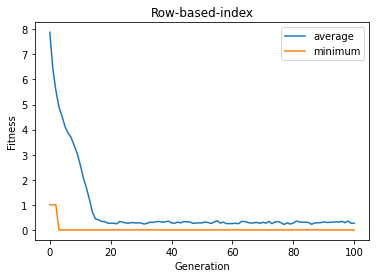

In [27]:
# Plot the "avg" and "min" for each generation
gen, avg, min_ = log.select("gen", "avg", "min")
plt.title("Row-based-index")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()

### 5 pts:  Print out the best individual and its fitness value. Show the best individual as chessboard.

In [28]:
best_ind = tools.selBest(pop, k=1)[0]

print('Best individual is:', best_ind)
print('Number of conflicts:', compute_conflicts(best_ind))
print_grid(best_ind, board_size)


Best individual is: [5, 2, 0, 7, 3, 1, 6, 4]
Number of conflicts: 0
-|-|-|-|-|X|-|-|
----------------
-|-|X|-|-|-|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|-|X|-|-|-|-|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
-|-|-|-|X|-|-|-|
----------------


### Reflection:  Which board representaion is better in terms of ease of coding and final solution quality?  Try different parameter values for mutation and crossover and vary the number of generations and the population size.  Write your findings in the report.        

We believe that row-index representation exceeds position-index representation in performance because we are able to put a constraint on one of the fundamental ways queens may attack each other, reducing our search space by a substantial amount. However, programming an evaluation function for this representation required viewing each queen's conflict as a complete graph, which is a much more complex algorithm than the one written for positional-indexing in order to compute collisions in linear time. In other words, row-index representation is more complex to program, but it also yields higher quality results.